# Komorbiditäts-Netzwerk-Analyse mit Graph Data Science
#### Ausfügung des Notebooks über Kernel-Restart; Bei weniger als 1000 Patienten nicht Empfohlen!; Synthea nicht deterministisch andere Ergebisse der Analysen
## Mittleres Level - Community Detection & Zentralitätsanalyse

**Zweck:** Anwendung von Graph Data Science Algorithmen zur Identifizierung von Krankheitsclustern und wichtigen Erkrankungen

**Was machen diese Algorithmen?**
- **Louvain Community Detection**: Findet Gruppen von Krankheiten, die häufig zusammen auftreten
- **PageRank**: Identifiziert "Hub"-Erkrankungen, die mit vielen anderen verbunden sind
- **Betweenness Centrality**: Findet "Brücken"-Erkrankungen zwischen verschiedenen Clustern

**Warum ist das wichtig?** Diese Analysen helfen, Risikopatienten zu identifizieren und zeigen, welche Erkrankungen besondere Aufmerksamkeit in der Behandlung benötigen.

**Datensatz:** Synthetische Patientendaten (Anzahl variiert je nach Generierung)

**Datum:** November 17, 2025


## Setup: Verbindung und Bibliotheken

In [1]:
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Stil setzen
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Verbindungseinstellungen
NEO4J_URI = "bolt://neo4j-synthea:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "synthea123"

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([dict(record) for record in result])

print("✅ Verbindung zu Neo4j hergestellt")


✅ Verbindung zu Neo4j hergestellt


## Schritt 1: GDS Graph Projektion erstellen

Zuerst erstellen wir einen benannten Graphen in GDS mit:
- **Knoten**: ChronicDisease (chronische Erkrankungen) mit Prävalenz-Eigenschaft
- **Beziehungen**: CO_OCCURS_WITH (tritt gemeinsam auf) mit cooccurrenceCount als Gewicht

Dies ist notwendig, damit die GDS-Algorithmen auf dem Graphen arbeiten können.

In [2]:
# Existierende Projektion löschen falls vorhanden
drop_query = """
CALL gds.graph.exists('comorbidity-network') YIELD exists
WITH exists WHERE exists
CALL gds.graph.drop('comorbidity-network') YIELD graphName
RETURN 'Gelöscht: ' + graphName as status
"""
try:
    result = run_query(drop_query)
    if not result.empty:
        print(result.iloc[0]['status'])
except:
    print("Keine existierende Projektion vorhanden")

# Neue Projektion erstellen
# WICHTIG: Verwendet 'weight' statt 'cooccurrenceCount' da nicht alle Beziehungen cooccurrenceCount haben
project_query = """
CALL gds.graph.project(
  'comorbidity-network',
  'ChronicDisease',
  {
    CO_OCCURS_WITH: {
      type: 'CO_OCCURS_WITH',
      orientation: 'UNDIRECTED',
      properties: 'weight'
    }
  },
  {
    nodeProperties: ['prevalence']
  }
)
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount
"""

projection = run_query(project_query).iloc[0]
print("\n" + "="*60)
print("GDS GRAPH PROJEKTION ERSTELLT")
print("="*60)
print(f"Graph Name:      {projection['graphName']}")
print(f"Knoten:          {projection['nodeCount']:,}")
print(f"Beziehungen:     {projection['relationshipCount']:,}")
print("="*60)


Gelöscht: comorbidity-network

GDS GRAPH PROJEKTION ERSTELLT
Graph Name:      comorbidity-network
Knoten:          204
Beziehungen:     13,204


## Schritt 2: Louvain Community Detection

**Was macht dieser Algorithmus?** Louvain identifiziert Cluster (Communities) von Erkrankungen, die häufig gemeinsam auftreten. Das hilft, Krankheitsmuster zu verstehen und zeigt, welche Erkrankungen ähnliche Ursachen oder Risikofaktoren haben könnten.

In [3]:
louvain_query = """
CALL gds.louvain.write(
  'comorbidity-network',
  {
    writeProperty: 'communityId',
    relationshipWeightProperty: 'weight',
    includeIntermediateCommunities: false
  }
)
YIELD communityCount, modularity, ranLevels
RETURN communityCount, round(modularity, 3) as modularity, ranLevels
"""

louvain_result = run_query(louvain_query).iloc[0]
print("\n" + "="*60)
print("LOUVAIN COMMUNITY DETECTION")
print("="*60)
print(f"Gefundene Communities:   {louvain_result['communityCount']:,}")
print(f"Modularitäts-Score:      {louvain_result['modularity']:.3f}")
print(f"Berechnete Ebenen:       {louvain_result['ranLevels']}")
print("="*60)
print("\nModularität > 0.3 = starke Community-Struktur")
print("   Modularität 0.1-0.3 = moderate Community-Struktur")



LOUVAIN COMMUNITY DETECTION
Gefundene Communities:   18.0
Modularitäts-Score:      0.112
Berechnete Ebenen:       2.0

Modularität > 0.3 = starke Community-Struktur
   Modularität 0.1-0.3 = moderate Community-Struktur


## Schritt 3: PageRank - Identifikation von Hub-Erkrankungen

**Was sind Hubs?** Erkrankungen, die mit besonders vielen anderen Erkrankungen verbunden sind. Diese spielen eine zentrale Rolle im Netzwerk und sind wichtig für die Behandlungsplanung.

In [4]:
pagerank_query = """
CALL gds.pageRank.write(
  'comorbidity-network',
  {
    writeProperty: 'pageRank',
    relationshipWeightProperty: 'weight',
    maxIterations: 100,
    dampingFactor: 0.85
  }
)
YIELD ranIterations, didConverge
RETURN ranIterations, didConverge
"""

pagerank_result = run_query(pagerank_query).iloc[0]
print("\n" + "="*60)
print("PAGERANK BERECHNUNG")
print("="*60)
print(f"Iterationen:     {pagerank_result['ranIterations']}")
print(f"Konvergiert:     {'Ja' if pagerank_result['didConverge'] else 'Nein'}")
print("="*60)
if not pagerank_result['didConverge']:
    print("\n⚠️ Hinweis: PageRank konvergierte nicht vollständig.")
    print("   Die Ergebnisse sind trotzdem verwendbar.")



PAGERANK BERECHNUNG
Iterationen:     89
Konvergiert:     Ja


## Schritt 4: Betweenness Centrality - Identifikation von Brücken-Erkrankungen

**Was sind Brücken?** Erkrankungen, die verschiedene Krankheitscluster miteinander verbinden. Sie sind wichtig, um zu verstehen, wie sich Erkrankungen gegenseitig beeinflussen können.

In [5]:
betweenness_query = """
CALL gds.betweenness.write(
  'comorbidity-network',
  {
    writeProperty: 'betweenness'
  }
)
YIELD centralityDistribution
RETURN centralityDistribution.min as min,
       round(centralityDistribution.mean, 2) as mean,
       round(centralityDistribution.max, 2) as max
"""

betweenness_result = run_query(betweenness_query).iloc[0]
print("\n" + "="*60)
print("BETWEENNESS CENTRALITY")
print("="*60)
print(f"Minimum:     {betweenness_result['min']}")
print(f"Mittelwert:  {betweenness_result['mean']}")
print(f"Maximum:     {betweenness_result['max']}")
print("="*60)



BETWEENNESS CENTRALITY
Minimum:     0.0
Mittelwert:  60.29
Maximum:     2449.0


## Analyse 1: Top 15 Hub-Erkrankungen (PageRank)

Diese Erkrankungen haben die meisten Verbindungen zu anderen Krankheiten und spielen eine zentrale Rolle im Netzwerk.


TOP 15 HUB-ERKRANKUNGEN (PageRank)

                                                            Erkrankung  Prävalenz  PageRank  Community
                                                 Gingivitis (disorder)       9236   14.9455         48
                               Body mass index 30+ - obesity (finding)       5428   10.1707         48
                                           Gingival disease (disorder)       5358    9.7768         48
                                                     Anemia (disorder)       4153    8.4183         48
                                     Essential hypertension (disorder)       2579    6.5253         66
Abnormal findings diagnostic imaging heart+coronary circulat (finding)       1867    5.3543         20
                                     Ischemic heart disease (disorder)       1854    5.3237         20
                                       Metabolic syndrome X (disorder)       1661    5.0218         20
                                    

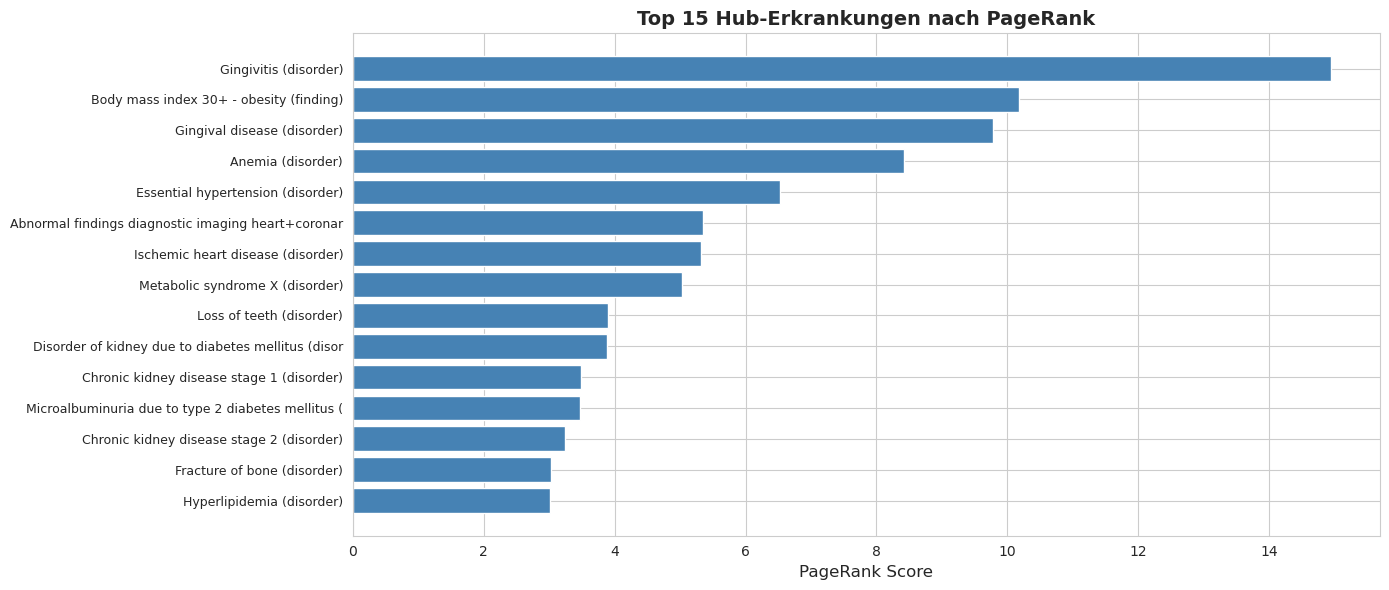

In [6]:
hub_query = """
MATCH (c:ChronicDisease)
WHERE c.pageRank IS NOT NULL
RETURN c.description as Erkrankung,
       c.prevalence as Prävalenz,
       round(c.pageRank, 4) as PageRank,
       c.communityId as Community
ORDER BY c.pageRank DESC
LIMIT 15
"""

hubs = run_query(hub_query)
print("\nTOP 15 HUB-ERKRANKUNGEN (PageRank)\n")
print(hubs.to_string(index=False))

# Visualisierung
plt.figure(figsize=(14, 6))
plt.barh(range(len(hubs)), hubs['PageRank'], color='steelblue')
plt.yticks(range(len(hubs)), [d[:50] for d in hubs['Erkrankung']], fontsize=9)
plt.xlabel('PageRank Score', fontsize=12)
plt.title('Top 15 Hub-Erkrankungen nach PageRank', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Analyse 2: Top 15 Brücken-Erkrankungen (Betweenness)

Diese Erkrankungen verbinden verschiedene Krankheitscluster und sind wichtig für die Ausbreitung von Komorbiditäten.


TOP 15 BRÜCKEN-ERKRANKUNGEN (Betweenness)

                                                            Erkrankung  Prävalenz  Betweenness  Community
                                                 Gingivitis (disorder)       9236      2448.99         48
                                                     Anemia (disorder)       4153       841.91         48
                                           Gingival disease (disorder)       5358       756.88         48
                               Body mass index 30+ - obesity (finding)       5428       653.92         48
                                     Essential hypertension (disorder)       2579       472.85         66
                                     Ischemic heart disease (disorder)       1854       388.56         20
Abnormal findings diagnostic imaging heart+coronary circulat (finding)       1867       388.56         20
                                       Metabolic syndrome X (disorder)       1661       388.18         20
  

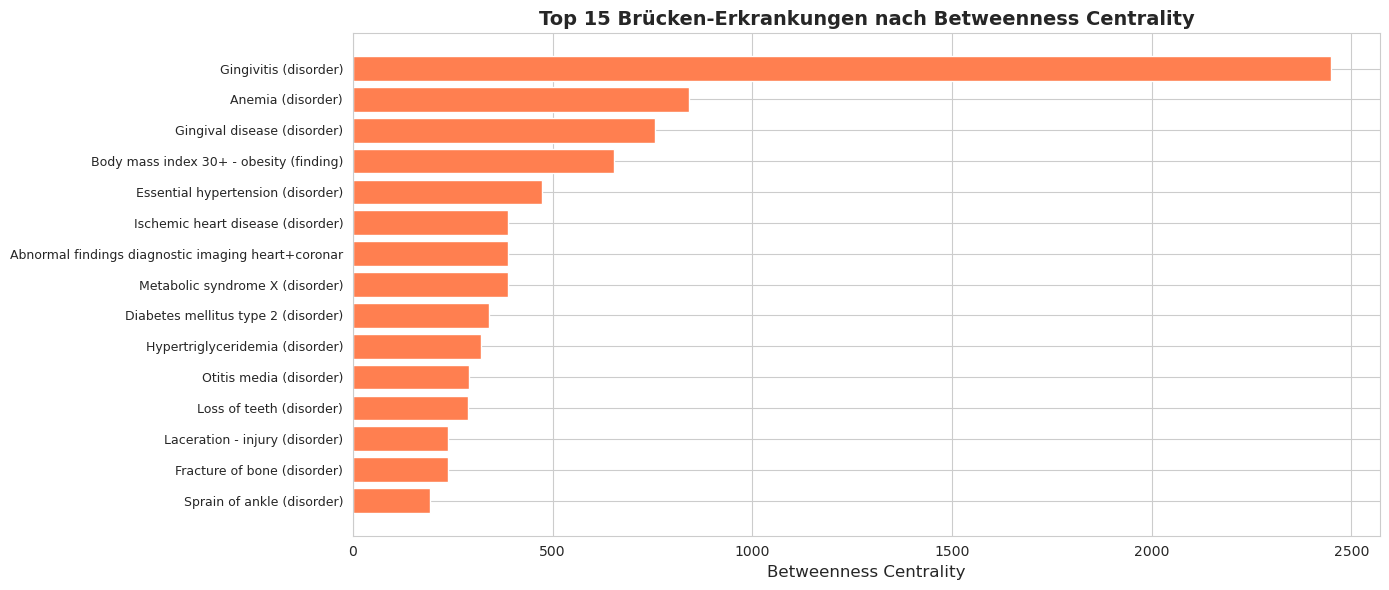

In [7]:
bridge_query = """
MATCH (c:ChronicDisease)
WHERE c.betweenness IS NOT NULL AND c.betweenness > 0
RETURN c.description as Erkrankung,
       c.prevalence as Prävalenz,
       round(c.betweenness, 2) as Betweenness,
       c.communityId as Community
ORDER BY c.betweenness DESC
LIMIT 15
"""

bridges = run_query(bridge_query)
print("\nTOP 15 BRÜCKEN-ERKRANKUNGEN (Betweenness)\n")
print(bridges.to_string(index=False))

# Visualisierung
plt.figure(figsize=(14, 6))
plt.barh(range(len(bridges)), bridges['Betweenness'], color='coral')
plt.yticks(range(len(bridges)), [d[:50] for d in bridges['Erkrankung']], fontsize=9)
plt.xlabel('Betweenness Centrality', fontsize=12)
plt.title('Top 15 Brücken-Erkrankungen nach Betweenness Centrality', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Analyse 3: Top 10 Krankheits-Communities

Communities sind Gruppen von Erkrankungen, die häufig gemeinsam auftreten. Jede Community repräsentiert ein typisches Komorbiditätsmuster.

In [8]:
community_query = """
MATCH (c:ChronicDisease)
WHERE c.communityId IS NOT NULL
WITH c.communityId as communityId, 
     collect(c.description) as diseases,
     count(c) as disease_count
ORDER BY disease_count DESC
LIMIT 10
WITH communityId, disease_count, diseases,
     // Zähle UNIQUE Patienten für diese Community
     [d IN diseases | d] as disease_list
MATCH (p:Patient)-[:HAS_CONDITION]->(cd:ChronicDisease)
WHERE cd.communityId = communityId
WITH communityId, disease_count, diseases[0..5] as sample_diseases, count(DISTINCT p) as unique_patients
RETURN communityId, 
       disease_count, 
       unique_patients,
       sample_diseases
ORDER BY disease_count DESC
"""

communities = run_query(community_query)
print("\nTOP 10 KRANKHEITS-COMMUNITIES\n")
for idx, row in communities.iterrows():
    print(f"\nCommunity {row['communityId']}: {row['disease_count']} Erkrankungen, {row['unique_patients']} unique Patienten")
    print("Beispiel-Erkrankungen:")
    for disease in row['sample_diseases']:
        print(f"  - {disease}")



TOP 10 KRANKHEITS-COMMUNITIES


Community 48: 85 Erkrankungen, 11070 unique Patienten
Beispiel-Erkrankungen:
  - Gingivitis (disorder)
  - Streptococcal sore throat (disorder)
  - Seizure disorder (disorder)
  - Epilepsy (disorder)
  - Gingival disease (disorder)

Community 20: 41 Erkrankungen, 3919 unique Patienten
Beispiel-Erkrankungen:
  - Cystic fibrosis (disorder)
  - Diabetes mellitus due to cystic fibrosis (disorder)
  - Diabetes mellitus type 2 (disorder)
  - Hypertriglyceridemia (disorder)
  - Mitral valve regurgitation (disorder)

Community 66: 32 Erkrankungen, 3916 unique Patienten
Beispiel-Erkrankungen:
  - Essential hypertension (disorder)
  - Loss of teeth (disorder)
  - Chronic kidney disease stage 1 (disorder)
  - Disorder of kidney due to diabetes mellitus (disorder)
  - Alveolitis of jaw (disorder)

Community 73: 20 Erkrankungen, 414 unique Patienten
Beispiel-Erkrankungen:
  - Pneumonia (disorder)
  - Septic shock (disorder)
  - Hypoxemia (disorder)
  - Acute pulmona

## Analyse 4: Größenverteilung der Communities

**Was zeigt diese Analyse?** Wie viele Communities welche Größe haben. Z.B. "1 Community mit 84 Erkrankungen" bedeutet, dass es eine große Community mit 84 verschiedenen Erkrankungen gibt, während "21 Communities mit 1 Erkrankung" bedeutet, dass es 21 isolierte Erkrankungen gibt, die keine starken Verbindungen zu anderen haben.


COMMUNITY-GRÖẞENVERTEILUNG

Community-Größe  |  Anzahl Communities
---------------------------------------------
85 Erkrankungen      |   1 Communities
41 Erkrankungen      |   1 Communities
32 Erkrankungen      |   1 Communities
20 Erkrankungen      |   1 Communities
7 Erkrankungen       |   1 Communities
5 Erkrankungen       |   1 Communities
3 Erkrankungen       |   1 Communities
1 Erkrankung         |  11 Communities


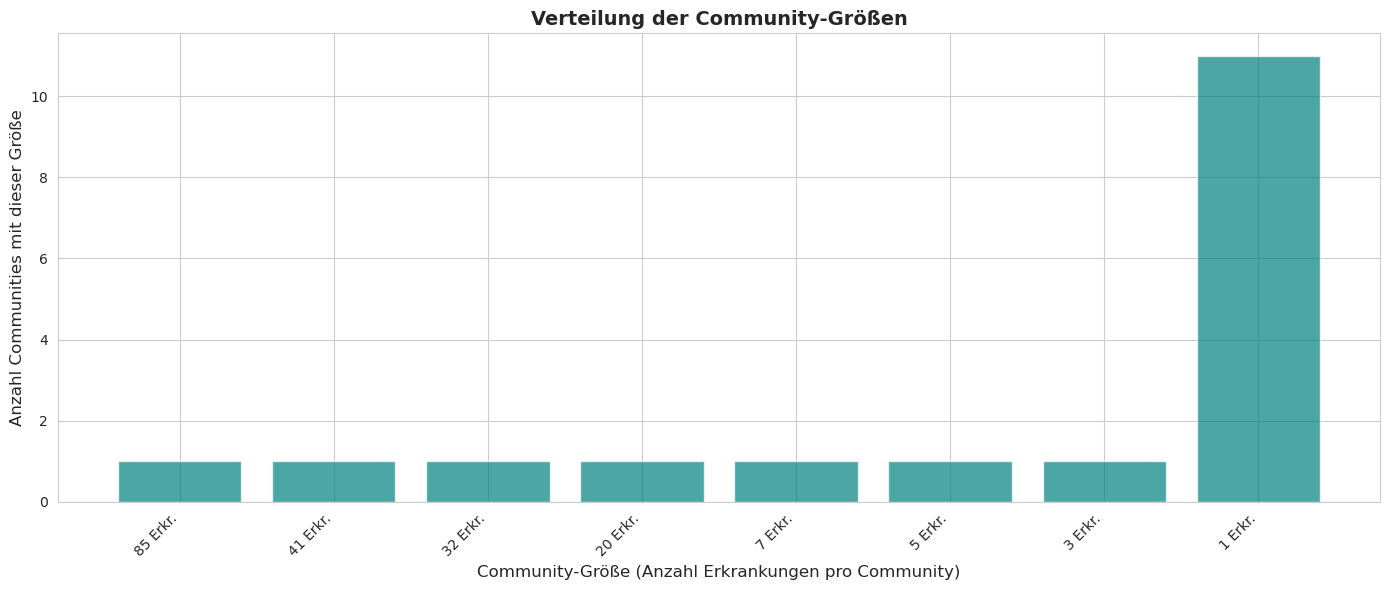


Interpretation:
   Gesamt Communities: 18
   Größte Community: 85 Erkrankungen
   Kleinste Community: 1 Erkrankung(en)
   Anzahl isolierter Erkrankungen (1 pro Community): 11


In [9]:
comm_dist_query = """
MATCH (c:ChronicDisease)
WHERE c.communityId IS NOT NULL
WITH c.communityId as community, count(c) as size
RETURN size, count(community) as communities
ORDER BY size DESC
"""

comm_dist = run_query(comm_dist_query)

# Bessere Darstellung: Gruppiere kleinere Communities
print("\nCOMMUNITY-GRÖẞENVERTEILUNG\n")
print("Community-Größe  |  Anzahl Communities")
print("-" * 45)
for idx, row in comm_dist.iterrows():
    size_label = f"{row['size']} Erkrankungen" if row['size'] > 1 else "1 Erkrankung"
    print(f"{size_label:20} | {row['communities']:3} Communities")

# Visualisierung
plt.figure(figsize=(14, 6))
# Erstelle bessere Labels
labels = [f"{s} Erkr." if s > 1 else "1 Erkr." for s in comm_dist['size']]
plt.bar(range(len(comm_dist)), comm_dist['communities'], color='teal', alpha=0.7)
plt.xticks(range(len(comm_dist)), labels, rotation=45, ha='right')
plt.xlabel('Community-Größe (Anzahl Erkrankungen pro Community)', fontsize=12)
plt.ylabel('Anzahl Communities mit dieser Größe', fontsize=12)
plt.title('Verteilung der Community-Größen', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
print(f"   Gesamt Communities: {comm_dist['communities'].sum()}")
print(f"   Größte Community: {comm_dist['size'].max()} Erkrankungen")
print(f"   Kleinste Community: {comm_dist['size'].min()} Erkrankung(en)")
print(f"   Anzahl isolierter Erkrankungen (1 pro Community): {comm_dist[comm_dist['size']==1]['communities'].sum() if len(comm_dist[comm_dist['size']==1]) > 0 else 0}")


## Analyse 5: Detailanalyse Metabolisches Syndrom

Überprüfung, ob die Erkrankungen des metabolischen Syndroms (Übergewicht, Diabetes, Bluthochdruck) tatsächlich im selben Cluster identifiziert wurden.

In [10]:
metabolic_query = """
MATCH (c:ChronicDisease)
WHERE c.description IN [
    'Body mass index 30+ - obesity (finding)',
    'Essential hypertension (disorder)',
    'Metabolic syndrome X (disorder)',
    'Diabetes mellitus type 2 (disorder)',
    'Hyperlipidemia (disorder)'
]
RETURN c.description as Erkrankung,
       c.prevalence as Prävalenz,
       c.communityId as Community,
       round(c.pageRank, 4) as PageRank,
       round(coalesce(c.betweenness, 0), 2) as Betweenness
ORDER BY c.prevalence DESC
"""

metabolic = run_query(metabolic_query)
print("\nMETABOLISCHES SYNDROM - CLUSTER\n")
print(metabolic.to_string(index=False))

# Prüfe ob sie in der gleichen Community sind
communities_in_cluster = metabolic['Community'].nunique()
print(f"\nDiese {len(metabolic)} Erkrankungen verteilen sich auf {communities_in_cluster} Community/Communities")
if communities_in_cluster == 1:
    print("   ✅ Alle metabolischen Syndrom-Erkrankungen sind in der GLEICHEN Community!")
else:
    print(f"   ⚠️  Erkrankungen sind auf {communities_in_cluster} Communities verteilt")



METABOLISCHES SYNDROM - CLUSTER

                             Erkrankung  Prävalenz  Community  PageRank  Betweenness
Body mass index 30+ - obesity (finding)       5428         48   10.1707       653.92
      Essential hypertension (disorder)       2579         66    6.5253       472.85
        Metabolic syndrome X (disorder)       1661         20    5.0218       388.18
              Hyperlipidemia (disorder)       1195         20    3.0096       188.65
    Diabetes mellitus type 2 (disorder)        850         20    2.8401       339.76

Diese 5 Erkrankungen verteilen sich auf 3 Community/Communities
   ⚠️  Erkrankungen sind auf 3 Communities verteilt


## Analyse 6: PageRank vs. Prävalenz Streudiagramm

Vergleich zwischen der Häufigkeit einer Erkrankung (Prävalenz) und ihrer Bedeutung im Netzwerk (PageRank). Zeigt verschiedene Muster:
- **Hoher PageRank + Hohe Prävalenz**: Häufige Hub-Erkrankungen
- **Hoher PageRank + Niedrige Prävalenz**: Seltene, aber stark vernetzte Erkrankungen
- **Niedriger PageRank + Hohe Prävalenz**: Häufige, aber isolierte Erkrankungen

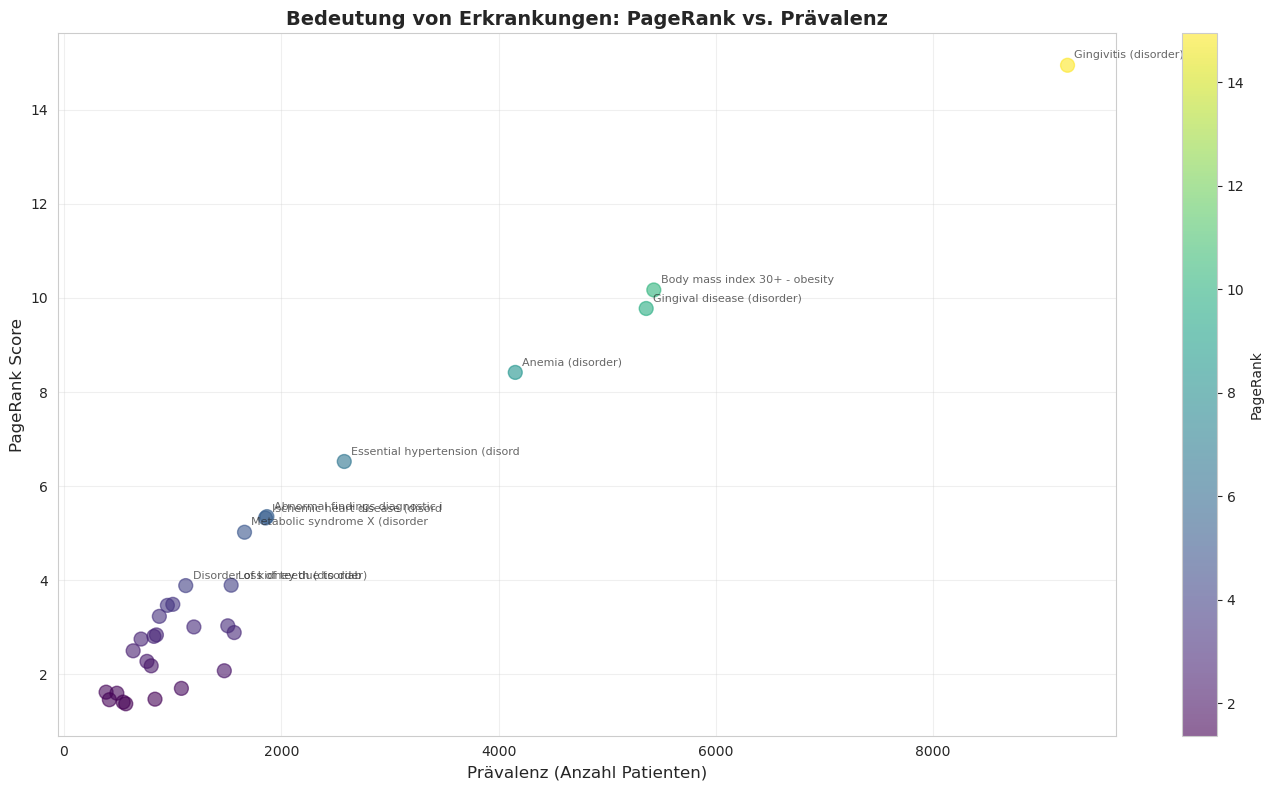


Interpretation:
   - Hoher PageRank + Hohe Prävalenz = Häufige Hub-Erkrankungen
   - Hoher PageRank + Niedrige Prävalenz = Seltene, aber stark vernetzte Erkrankungen
   - Niedriger PageRank + Hohe Prävalenz = Häufige, aber isolierte Erkrankungen


In [11]:
scatter_query = """
MATCH (c:ChronicDisease)
WHERE c.pageRank IS NOT NULL AND c.prevalence > 10
RETURN c.description as Erkrankung,
       c.prevalence as Prävalenz,
       round(c.pageRank, 4) as PageRank
ORDER BY c.pageRank DESC
LIMIT 30
"""

scatter_data = run_query(scatter_query)

if scatter_data.empty:
    print("⚠️ Keine Daten gefunden - PageRank wurde möglicherweise noch nicht berechnet. Führen Sie zuerst die GDS-Queries aus!")
else:
    plt.figure(figsize=(14, 8))
    plt.scatter(scatter_data['Prävalenz'], scatter_data['PageRank'], 
               s=100, alpha=0.6, c=scatter_data['PageRank'], cmap='viridis')
    
    # Beschrifte Top 10
    for idx in range(min(10, len(scatter_data))):
        plt.annotate(scatter_data.iloc[idx]['Erkrankung'][:30], 
                    xy=(scatter_data.iloc[idx]['Prävalenz'], scatter_data.iloc[idx]['PageRank']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)
    
    plt.xlabel('Prävalenz (Anzahl Patienten)', fontsize=12)
    plt.ylabel('PageRank Score', fontsize=12)
    plt.title('Bedeutung von Erkrankungen: PageRank vs. Prävalenz', fontsize=14, fontweight='bold')
    plt.colorbar(label='PageRank')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretation:")
    print("   - Hoher PageRank + Hohe Prävalenz = Häufige Hub-Erkrankungen")
    print("   - Hoher PageRank + Niedrige Prävalenz = Seltene, aber stark vernetzte Erkrankungen")
    print("   - Niedriger PageRank + Hohe Prävalenz = Häufige, aber isolierte Erkrankungen")


## Abschluss: Aufräumen

In [12]:
driver.close()
print("✅ Verbindung geschlossen")
print("\nUm die GDS-Projektion zu löschen, führen Sie aus:")
print("   CALL gds.graph.drop('comorbidity-network')")


✅ Verbindung geschlossen

Um die GDS-Projektion zu löschen, führen Sie aus:
   CALL gds.graph.drop('comorbidity-network')
